In [31]:
import re
from pathlib import Path

import openai
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys

ROOT_DIR = Path("..")
OUTPUT_DIR = ROOT_DIR / 'output'
GROBID_DIR = OUTPUT_DIR / 'group_selection_grobid'
SPACY_DIR = OUTPUT_DIR / 'spacy_group_selection_grobid'
CCA_DIR = OUTPUT_DIR / 'cca'

In [2]:
df = pd.read_parquet(OUTPUT_DIR/"groupSel_feud_with_tag.parquet")

In [3]:
df2 = pd.read_parquet(OUTPUT_DIR / "My-Predictions2_with_multicite.parquet")

In [4]:
len(df)

97558

In [5]:
df.head()

,aid,sid,did,article,parsed_doc,cite_spans,citationCounts,ID,year,author
0,1,1,0,puhalskii_large-population_2017,By the 1960's Darwin's thoughts on this topic ...,J Maynard-Smith,0.0,puhalskii_large-population_2017,2017-01-01,"Puhalskii, A. and Simon, B."
1,2,1,0,puhalskii_large-population_2017,By the 1960's Darwin's thoughts on this topic ...,G Williams,0.0,puhalskii_large-population_2017,2017-01-01,"Puhalskii, A. and Simon, B."
2,3,1,0,puhalskii_large-population_2017,By the 1960's Darwin's thoughts on this topic ...,G Williams,0.0,puhalskii_large-population_2017,2017-01-01,"Puhalskii, A. and Simon, B."
3,4,1,0,puhalskii_large-population_2017,By the 1960's Darwin's thoughts on this topic ...,R Dawkins,0.0,puhalskii_large-population_2017,2017-01-01,"Puhalskii, A. and Simon, B."
4,5,1,0,puhalskii_large-population_2017,By the 1960's Darwin's thoughts on this topic ...,W Hamilton,0.0,puhalskii_large-population_2017,2017-01-01,"Puhalskii, A. and Simon, B."


### How many words by paragraph parsed by GROBID?

In [6]:
df_count = df.parsed_doc.str.split(" ").map(len).reset_index(name="n")
avg_count = df_count.n.mean()

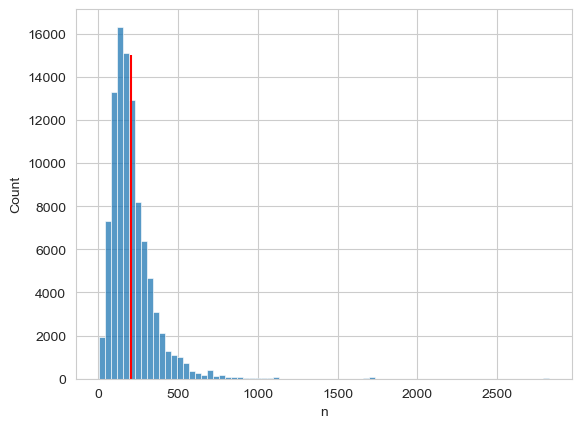

In [7]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1)
sns.histplot(df_count.n, bins=75, ax=ax)
ax.vlines(x=avg_count, ymin=0, ymax=15_000, color="red");

In [8]:
print(f"Avg word count/paragraph: {avg_count}")

Avg word count/paragraph: 206.45466286721745


#### Most common identified authors?

In [9]:
df_count = df.value_counts("cite_spans").reset_index(name="n")

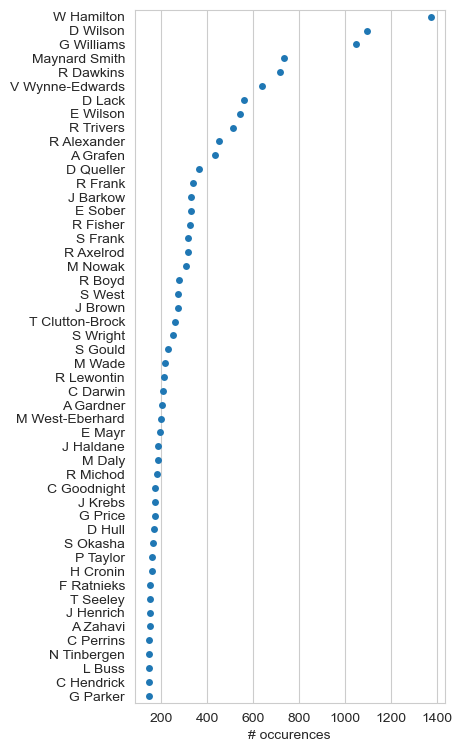

In [10]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(4,9))
sns.stripplot(x="n", y="cite_spans", data=df_count.head(50), ax=ax)
ax.set_ylabel("")
ax.set_xlabel("# occurences");

In [11]:
print(f"There are {len(df.cite_spans.unique())} unique authors")
print(f"On average, people get cited {df_count.n.mean()}")

There are 19962 unique authors
On average, people get cited 4.887185652740206


We note that some authors are junk.

In [12]:
df_count[(df_count.n > 30) & (df_count.cite_spans.str.len() > 2)].cite_spans.to_csv(OUTPUT_DIR / "list_hotshots.csv", index=False)

#### What is the time series of articles and paragraph?

In [13]:
df_count = df[~df.article.duplicated()].value_counts("year").reset_index(name="n")
df_count["year"] = pd.to_datetime(df_count.year, format="%Y")

df_count_par = df.value_counts("year").reset_index(name="n")
df_count_par["year"] = pd.to_datetime(df_count.year, format="%Y")

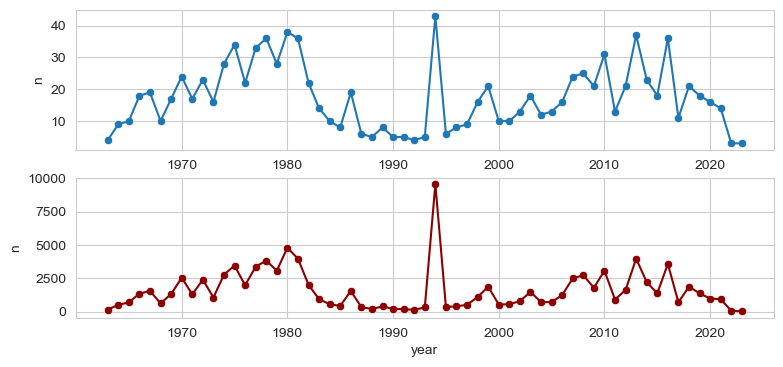

In [14]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 4))
sns.scatterplot(x="year", y="n", data=df_count, ax=ax1)
sns.lineplot(x="year", y="n", data=df_count, ax=ax1)

sns.scatterplot(x="year", y="n", color="darkred", data=df_count_par, ax=ax2)
sns.lineplot(x="year", y="n", color="darkred", data=df_count_par, ax=ax2);

#### What is the loglog citation count of authors?

In [15]:
df_count = df[~df.article.duplicated()].value_counts("citationCounts").reset_index(name="n")
df_count['rank'] = df_count.n.rank(ascending=False)

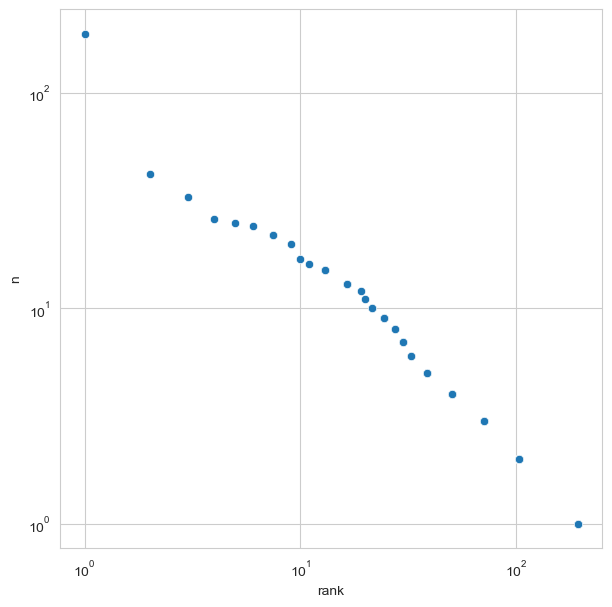

In [16]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(7, 7))
sns.scatterplot(x='rank', y="n", data=df_count, ax=ax)
ax.set_xscale('log')
ax.set_yscale('log');

#### What is the distribution of mutliple authors ina  same sentence?

In [125]:
df_count = df.value_counts(['year', 'did', 'sid']).reset_index(name='n')
df_count['rank'] = df_count.n.rank(ascending=False)
df_count.head(5)

,year,did,sid,n,rank
0,1977-01-01,32,1200,60,1.0
1,2020-01-01,724,29735,56,2.0
2,2008-01-01,545,22917,52,3.0
3,2011-01-01,675,27921,48,4.0
4,2007-01-01,627,26146,45,5.0


In [123]:
df_count.tail(5)

,year,did,sid,n,rank
32840,1994-01-01,318,13348,1,26041.5
32841,1994-01-01,318,13346,1,26041.5
32842,1994-01-01,318,13343,1,26041.5
32843,1994-01-01,318,13341,1,26041.5
32844,1994-01-01,1016,38711,1,26041.5


/tmp/ipykernel_226526/1255299760.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((3, 3), (0, 0))


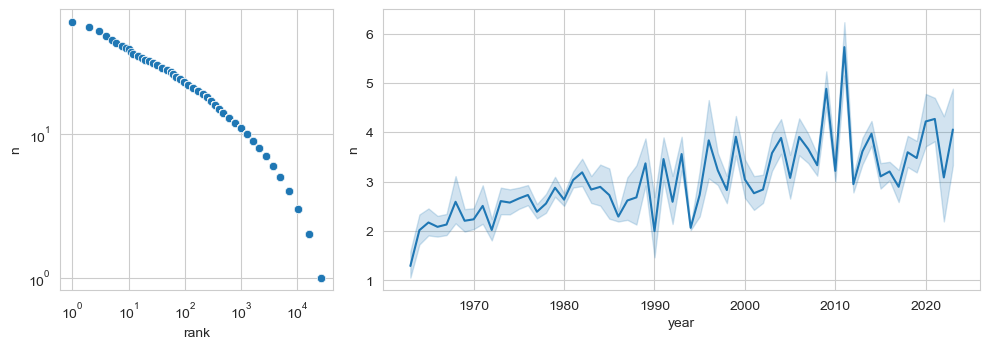

In [124]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
sns.scatterplot(x='rank', y="n", data=df_count, ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
sns.lineplot(x="year", y="n", data=df_count, ax=ax2)
plt.tight_layout();

Extreme case:

In [21]:
df[(df.did==32) & (df.sid==1200)].parsed_doc.iloc[0]

'In addition to vertical migratory assemblages, other types of migratory assemblages are also common among marine crustaceans. Many migrations are associated with or are in response to environmental varia tion, including: seasonal migrations <cite>(Rathbun, 1918;</cite>Russell, 1927; Panning, 1938; Bogorov, 1946 Bogorov, , 1958 Lloyd and Yonge, 1947; Moore et al., 1953; Lindberg, 1955; Marshall and Orr, 1955; Verwey, 1958; Pike and Williamson, 1959; Moore and Bauer, 1960; Bainbridge, 1961; Banse, 1964; Allen, 1966; Rebach, 1968 Rebach, , 1974 Ricketts and Calvin, 1968; Fish, 1970; Cooper and Uzmann, 1971; Naylor, Atkinson, and Williams, 1971; Rodriguez and Naylor, 1972; Atkinson and Parsons, 1973; Fotheringham, 1975) , tidal migrations (Forster, 1951; Edwards, 1958; Verwey, 1958; Enright, 1961 Enright, , 1962 Enright, , 1963 Efford, 1965; Morgan, 1965 Morgan, , 1967 Allen, 1966; Hughes, 1969 Hughes, , 1972 Cubit, 1969; Jones and Naylor, 1970; Naylor et al., 1971; Preece, 1971; Rodrigue

In [22]:
df[(df.did==32) & (df.sid==1200)].cite_spans.unique()

array(['M Rathbun', 'F Russell', 'A Panning', 'B Bogorov', 'A Lloyd',
       'H Moore', 'R Lindberg', 'S Marshall', 'J Verwey', 'R Pike',
       'R Bainbridge', 'K Banse', 'J Allen', 'S Rebach', 'E Ricketts',
       'S Fish', 'R Cooper', 'E Naylor', 'G Rodriguez', 'R Atkinson',
       'N Fotheringham', 'G Forster', 'R Edwards', 'J Enright',
       'I Efford', 'E Morgan', 'D Hughes', 'J Cubit', 'D Jones',
       'G Preece', 'E Watkin', 'W Sutcliffe', 'C Gifford', 'G Warner',
       'L Klapow', 'W Hamner', 'W Macnae', 'W Herrnkind', 'W Wieser',
       'P Digby'], dtype=object)

### Citation type and stance

In [118]:
myorder = df2.groupby("context_type")['stance'].mean().sort_values(ascending=False).keys()

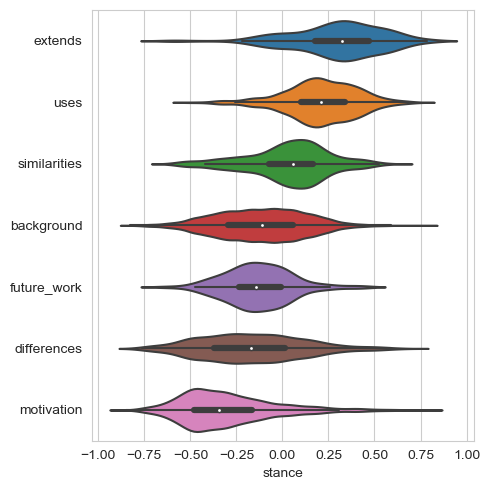

In [121]:
f, ax = plt.subplots(1,1, figsize=(5,5))
sns.violinplot(y="context_type", x="stance", data=df2, order=myorder, ax=ax)
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("stance_context_type.pdf");

In [60]:
df2.value_counts('context_type') / df2.value_counts('context_type').sum() * 100

context_type
background      83.122074
motivation      10.329947
differences      2.708685
uses             2.144973
similarities     1.130609
extends          0.404471
future_work      0.159241
dtype: float64

In [68]:
df2 = df2[df2.year != 'Kurt et al. - 2021 - Two-dimensionally stable self-organization arises ']
df2['year'] = df2.year.map(lambda x: x.split("-")[0])

/tmp/ipykernel_226526/395582527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = df2.year.map(lambda x: x.split("-")[0])


In [69]:
df2['year'] = pd.to_datetime(df2.year, format="%Y")
df2_count = df2.value_counts(["year", "context_type"]).reset_index(name="n");

/tmp/ipykernel_226526/4040833653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = pd.to_datetime(df2.year, format="%Y")


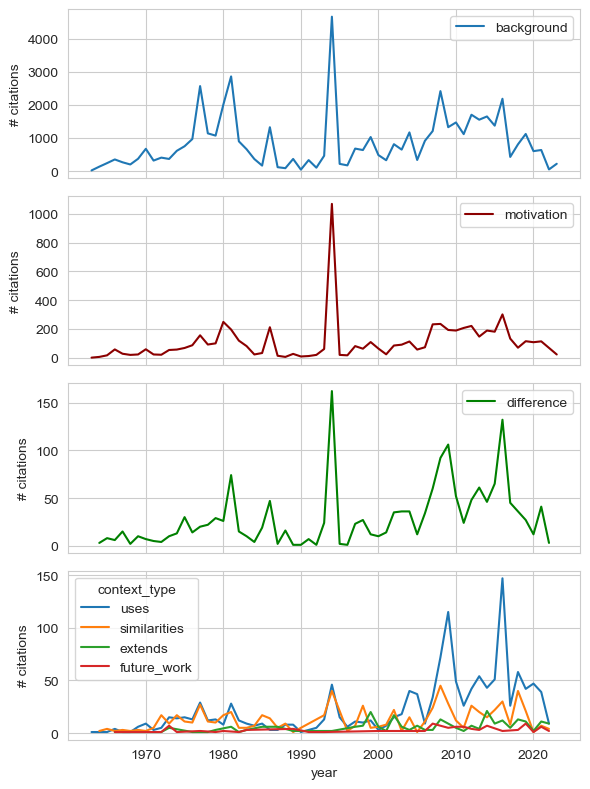

In [98]:
sns.set_style("whitegrid")
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
ax1.set_ylabel("# citations")
sns.lineplot(x="year", y="n", data=df2_count.query("context_type == 'background'"), label="background", ax=ax1)
ax2.set_ylabel("# citations")
sns.lineplot(x="year", y="n", data=df2_count.query("context_type == 'motivation'"),label="motivation", color="darkred", ax=ax2)
ax3.set_ylabel("# citations")
sns.lineplot(x="year", y="n", data=df2_count.query("context_type == 'differences'"), label="difference", color="green",ax=ax3)
ax4.set_ylabel("# citations")
sns.lineplot(x="year", y="n", hue="context_type", data=df2_count[df2_count.context_type.isin(['uses','similarities', 'extends','future_work'])], ax=ax4);
plt.tight_layout()
plt.savefig("citation_type.pdf")
plt.savefig("citation_type.png")

In [105]:
df2_count.merge(df2.value_counts("year").reset_index(name='tot_n'), how='left', on='year')\
     .assign(prop = lambda x: x.n / x.tot_n)\
     .to_csv("prop2plot.csv", index=False)